<span style="color:red"> *Contrary to expectation, this does not work (yet)*</span>

see https://github.com/OptimalScale/LMFlow/issues/726

# LISA

yet another PEFT

**Paper**: 
* LISA: Layerwise Importance Sampling for Memory-Efficient Large Language Model Fine-Tuning
* https://arxiv.org/abs/2403.17919

**Code**: https://github.com/OptimalScale/LMFlow

**LISA Approach**:
* Load all parameters, train a subset only, freeze the rest
* randomly select `lisa_activated_layers` number of layers and set `requires_grad=True`
* switch layers every `lisa_interval_steps` steps

**Integration with HF Trainer**:
* via Trainer Callback `DynamicLayerActivationCallback`
* init with params `lisa_activated_layers` and `lisa_interval_steps`
* `on_step_begin`: check current `step` vs `lisa_interval_steps`, call `switch_active_layers`

**Code below**:
* Load llama2-7b and prepare for ChatML
* Load Open Assistant data(sub)set, 4k examples
* `SFTTrainer` with constant LR of `2e-5` (`paged_adamw_8bit`), batch size 16, max seq. length 512. eval and save after each epoch
* Setup Trainer Callback with `lisa_activated_layers = 1` and `lisa_interval_steps = 20`
* Log with wandb
* 3 epochs in ~1.5hrs on a 3090 (VRAM usage ~21GB)

**Note**: seems to work, not thoroughly tested though

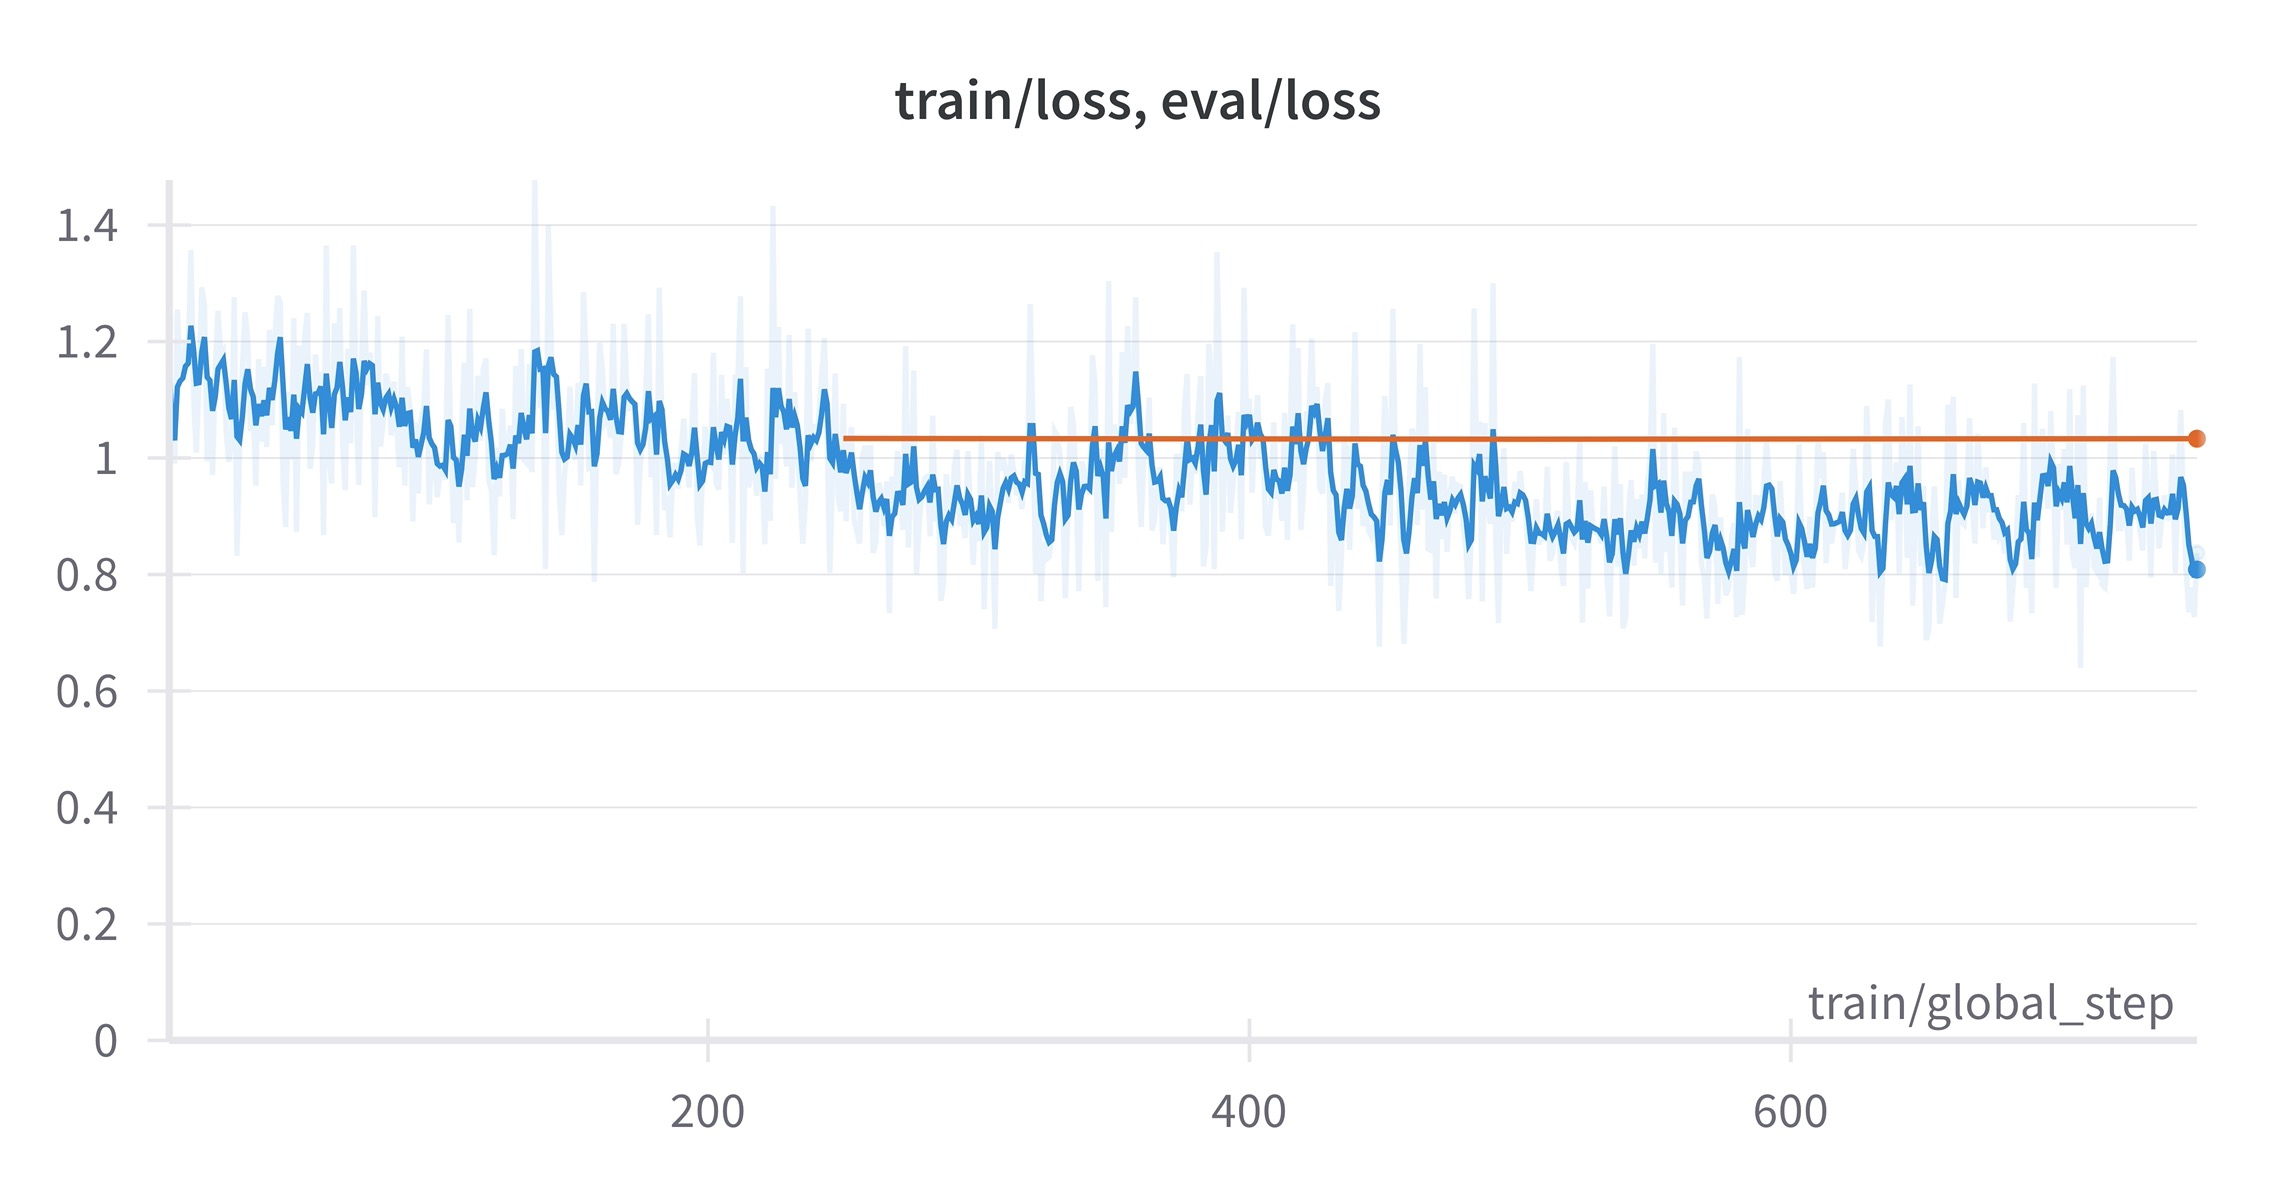

## Prerequisites

In [1]:
# !pip install -U bitsandbytes wandb flash_attn accelerate datasets trl transformers tokenizers 

## Load model, tokenizer, dataset

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, set_seed, get_constant_schedule
from trl import SFTTrainer, setup_chat_format, DataCollatorForCompletionOnlyLM
from datasets import load_dataset
import torch, uuid, wandb

set_seed(42)
run_id = f"LISA-{str(uuid.uuid4())}"

modelpath = "models/llama2-7b"

model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    torch_dtype = torch.bfloat16,
    attn_implementation = "flash_attention_2",  
    device_map = "auto",
    use_cache = False,
)
tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast = False)

model, tokenizer = setup_chat_format(model, tokenizer)
if tokenizer.pad_token in [None, tokenizer.eos_token]: 
    tokenizer.pad_token = tokenizer.unk_token

dataset = load_dataset("g-ronimo/oasst2_top4k_en")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Setup `SFTTrainer`

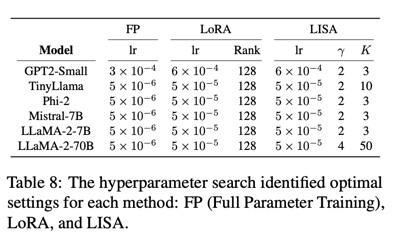

In [3]:
lr = 5e-5

training_arguments = TrainingArguments(
    output_dir = f"out_{run_id}",
    evaluation_strategy = "steps",
    label_names = ["labels"],
    per_device_train_batch_size = 16,
    save_steps = 250,
    eval_steps = 250,
    logging_steps = 1, 
    learning_rate = lr,
    num_train_epochs = 3,
    lr_scheduler_type = "constant",
    gradient_checkpointing = True,
    group_by_length = False,
    optim="paged_adamw_8bit",
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset['test'],
    data_collator = DataCollatorForCompletionOnlyLM(
        instruction_template = "<|im_start|>user", 
        response_template = "<|im_start|>assistant", 
        tokenizer = tokenizer, 
        mlm = False),
    max_seq_length = 512,
    dataset_kwargs = dict(add_special_tokens = False),
    args = training_arguments,
)

/home/g/.local/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Setup LISA

[Authors](https://arxiv.org/pdf/2403.17919.pdf):
> Generally, the rule of thumb is: More sampling layers
and higher sampling period lead to better performance.

32x `LlamaDecoderLayer` in llama2-7b:
* `lisa_activated_layers = 8` -> 25% trainable parameters
* `lisa_activated_layers = 4` -> 12.5% trainable parameters
* `lisa_activated_layers = 2` -> 6.25% trainable parameters

In [4]:
lisa_activated_layers = 8
lisa_interval_steps = 5

In [5]:
from transformers import TrainerCallback
import numpy as np

# source: https://github.com/OptimalScale/LMFlow/blob/main/src/lmflow/pipeline/finetuner.py
class DynamicLayerActivationCallback(TrainerCallback):
    def __init__(self, n_layers, interval_steps, model):
        super().__init__()
        self.n_layers = n_layers
        self.interval_steps = interval_steps
        self.model = model
        # Determine the way to access layers based on the model type
        if self.model.__class__.__name__ == 'LlamaForCausalLM':
            self.layers_attribute = 'model.model.layers'  # Layer access path for LlamaForCausalLM
        else:
            self.layers_attribute = 'model.transformer.h'  # General access path
        self.total_layers = len(eval('self.' + self.layers_attribute))  # Dynamically execute to get the number of layers

        # Freeze all layers upon initialization
        self.freeze_all_layers()
        self.active_layers_indices = []

    def freeze_all_layers(self):
        layers = eval('self.' + self.layers_attribute)  # Dynamically execute to get layers
        for layer in layers:
            for param in layer.parameters():
                param.requires_grad = False

    def on_step_begin(self, args, state, control, **kwargs):
        # Check if it's time to switch active layers, including at step 0
        if state.global_step % self.interval_steps == 0 or state.global_step == 1:
            self.switch_active_layers()

    def switch_active_layers(self):
        # First, disable gradients for all layers
        self.freeze_all_layers()

        # Randomly select n_layers to activate
        layers = eval('self.' + self.layers_attribute)  # Re-fetch layer references
        self.active_layers_indices = np.random.choice(range(self.total_layers), self.n_layers, replace=False)
        print(f"Activating layers at indices: {self.active_layers_indices} for the next steps.")

        # Enable gradients only for the selected layers
        for idx in self.active_layers_indices:
            for param in layers[idx].parameters():
                param.requires_grad = True

# Instantiate the callback
dynamic_layer_activation_callback = DynamicLayerActivationCallback(
    n_layers = lisa_activated_layers,                     # Number of layers to activate
    interval_steps = lisa_interval_steps,               # Step interval to update active layers
    model = model
)

trainer.add_callback(dynamic_layer_activation_callback)

## Train

In [ ]:
wandb.init(
    project = "LISA-7B", 
    name = run_id,
)#.log_code(include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

trainer.train()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo. Use `wandb login --relogin` to force relogin


/home/g/.local/lib/python3.10/site-packages/trl/trainer/utils.py:168: UserWarning: Could not find response key `<|im_start|>assistant` in the following instance: <|im_start|> user
Answer as an expert in medical malpractice law in the UK, presenting your arguments to another lawyer. Identify if this constitutes a breach of duty and a settlement value broken down by how the different factors affect the amount. Justify it step by step.
Our client’s mother approached our specialist erb’s palsy solicitors after realising that her son, Peter, may be eligible to claim compensation for the injuries he sustained during birth.
During her pregnancy with Peter, his mother had attended all of the scans and they showed a baby of normal size. However, during her labour, it became apparent that Peter was quite a big baby and, due to this, they took his mother to theatre to monitor her progress.
Peter’s head was delivered first, but due to his size, his shoulders became stuck (shoulder dystocia). Multi

Activating layers at indices: [29 15 24 17  8  9 30 25] for the next steps.


/home/g/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Activating layers at indices: [10  7  0 21  5 16 26 12] for the next steps.
Activating layers at indices: [30  0 22 31 18 28 10 15] for the next steps.
Activating layers at indices: [26 20  5  1 17 13 25  3] for the next steps.
Activating layers at indices: [17 18  1  5  3 15 24 25] for the next steps.
Activating layers at indices: [15  4 31  2  7 16  0 23] for the next steps.


/home/g/.local/lib/python3.10/site-packages/trl/trainer/utils.py:168: UserWarning: Could not find response key `<|im_start|>assistant` in the following instance: <|im_start|> user
these are some examples of "stable diffusion prompts" (ai that generates images using text as input).

example 1: portrait of a young ruggedly handsome but stern warrior in golden armor, male, light brown skin, muscular, masculine, upper body, red crimson hair, long flowing hair, fantasy, symmetrical face, golden eyes, intricate, elegant, highly detailed, digital painting, artstation, concept art, matte, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha.

example 2: Girl playing on the computer PC, wearing a baggy hoodie and black tophat, masterpiece, best quality, CG, wallpaper, HDR, high quality, high-definition, extremely detailed, 1girl, bilibili, wide shot.

example 3: Keanu Reeves portrait photo of a asia old warrior chief, tribal panther make up, blue on red, side profile,

Activating layers at indices: [30 15 10 17 26 25 23 21] for the next steps.
Activating layers at indices: [ 9 12 15  6 14 24  2 13] for the next steps.


/home/g/.local/lib/python3.10/site-packages/trl/trainer/utils.py:168: UserWarning: Could not find response key `<|im_start|>assistant` in the following instance: <|im_start|> user
Please have a look at the following hexdump and analyze it

```0000000 203b 6f4d 7564 656c 4449 3d20 2720 7270
0000010 626f 3065 342e 3133 3730 3332 2d30 6763
0000020 2e75 2730 730a 756f 6372 5f65 6966 656c
0000030 616e 656d 3d20 2220 7270 626f 3065 342e
0000040 3133 3730 3332 2d30 6763 2e75 2230 740a
0000050 7261 6567 2074 6164 6174 616c 6f79 7475
0000060 3d20 2220 2d65 3a6d 2d65 3270 3037 333a
0000070 3a32 3233 702d 3732 3a31 3233 333a 2d32
0000080 3270 3237 363a 3a34 3436 692d 3436 363a
0000090 2d34 3866 3a30 3231 2d38 386e 313a 3a36
00000a0 3233 3 This instance will be ignored in loss calculation. Note, if this happens often, consider increasing the `max_seq_length`.
  warnings.warn(
/home/g/.local/lib/python3.10/site-packages/trl/trainer/utils.py:183: UserWarning: Could not find instruction key `<|im_sta

Activating layers at indices: [13 14 15 30  4 20  5 12] for the next steps.
Activating layers at indices: [22 13 20  4  6  9 26 14] for the next steps.
Activating layers at indices: [27 17  1 21 18 30 25  4] for the next steps.
Activating layers at indices: [ 1 28  9 12 17 10  6 23] for the next steps.
Activating layers at indices: [22 11  4  3 20 15 28 26] for the next steps.
Activating layers at indices: [20  4 29 26 27 16 28 31] for the next steps.
Activating layers at indices: [24 30 13 23  8 10 26 17] for the next steps.
Activating layers at indices: [ 3 31 30 23 29 18 19 13] for the next steps.
Activating layers at indices: [ 5 22 26 10 24 14  8 17] for the next steps.
Activating layers at indices: [29 22  5  3  8 24  6 16] for the next steps.
Activating layers at indices: [22 11 15 23 16  5 14 30] for the next steps.
Activating layers at indices: [ 1  7 30  5  0 10  9 13] for the next steps.
Activating layers at indices: [16 31 19  7 17  1 27 25] for the next steps.


/home/g/.local/lib/python3.10/site-packages/trl/trainer/utils.py:168: UserWarning: Could not find response key `<|im_start|>assistant` in the following instance: <|im_start|> user
Can you write a TL;DR for the following paragraphs:

Messi was born on 24 June 1987 in Rosario, Santa Fe,[8] the third of four children of Jorge Messi, a steel factory manager, and his wife Celia Cuccittini, who worked in a magnet manufacturing workshop. On his father's side, he is of Italian and Spanish descent, the great-grandson of immigrants from the north-central Adriatic Marche region of Italy, and on his mother's side, he has primarily Italian ancestry.[3] Growing up in a tight-knit, football-loving family, "Leo" developed a passion for the sport from an early age, playing constantly with his older brothers, Rodrigo and Matías, and his cousins, Maximiliano and Emanuel Biancucchi, both of whom became professional footballers.[9] At the age of four he joined local club Grandoli, where he was coached by h

Activating layers at indices: [24 25 31 22 29  8 10  9] for the next steps.
Activating layers at indices: [17  9 30  1 20 26 28 23] for the next steps.
